## VCD 结果可视化
该脚本将VCD的多语言结果通过matplotlib可视化出来
### 1.导入必要的包

In [31]:
import os
import json
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import font_manager
import numpy as np

from language_dict import language_dict

### 2.定义工具函数

In [79]:
def generate_sequence():
    i = 0
    while True:
        yield i
        i = -i if i > 0 else -i + 1
def generate_sequence(num):
    i = -num/2
    while i < num:
        yield i
        i = i+1

def compare_str_list(str1,str2):
    if isinstance(str1,list):
        for i in str1:
            if i in str2:
                return True
        return False
    elif isinstance(str1,str):
        return str1 in str2
    else:
        raise ValueError("str1 should be list or str")
        
def eval_pope(gt_file,gen_file,language='en'):
    
    # open ground truth answers
    gt_files = [json.loads(q) for q in open(os.path.expanduser(gt_file), "r")]
    # open generated answers
    gen_files = [json.loads(q) for q in open(os.path.expanduser(gen_file), "r")]
    # calculate precision, recall, f1, accuracy, and the proportion of 'yes' answers
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    unknown = 0
    total_questions = len(gt_files)
    yes_answers = 0

    # compare answers
    for index, line in enumerate(gt_files):
        idx = line["question_id"]
        gt_answer = line["label"]
        assert idx == gen_files[index]["question_id"]
        gen_answer = gen_files[index]["text"]
        # convert to lowercase
        gt_answer = gt_answer.lower()
        gen_answer = gen_answer.lower()
        # strip
        gt_answer = gt_answer.strip()
        gen_answer = gen_answer.strip()
        # pos = 'yes', neg = 'no'
        pos = language_dict[language]['yes']
        neg = language_dict[language]['no']
        if compare_str_list(pos,gen_answer) and compare_str_list(neg,gen_answer):
            print("invalid answer")
            unknown+=1
            continue
        if compare_str_list(pos,gt_answer): 
                if compare_str_list(pos,gen_answer) :
                    true_pos += 1
                    yes_answers += 1
                else:
                    false_neg += 1
        elif compare_str_list(neg,gt_answer) :
                if compare_str_list(neg,gen_answer) :
                    true_neg += 1
                else:
                    yes_answers += 1
                    false_pos += 1
        else:
                print(f'Warning: unknown gt_answer: {gt_answer}')
                unknown += 1
    # calculate precision, recall, f1, accuracy, and the proportion of 'yes' answers
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / total_questions
    yes_proportion = yes_answers / total_questions
    unknown_prop = unknown / total_questions
    
    res = {
        "language": language,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "yes_proportion": yes_proportion,
        "unknown_prop": unknown_prop
    }
    return res

def eval_instruction_following(gt_file,gen_file,language='en'):
    # open ground truth answers
    gt_files = [json.loads(q) for q in open(os.path.expanduser(gt_file), "r")]
    # open generated answers
    gen_files = [json.loads(q) for q in open(os.path.expanduser(gen_file), "r")]
    # calculate precision, recall, f1, accuracy, and the proportion of 'yes' answers
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    unknown = 0
    total_questions = len(gt_files)
    yes_answers = 0

    # compare answers
    for index, line in enumerate(gt_files):
        idx = line["question_id"]
        gt_answer = line["label"]
        assert idx == gen_files[index]["question_id"]
        gen_answer = gen_files[index]["text"]
        # convert to lowercase
        gt_answer = gt_answer.lower()
        gen_answer = gen_answer.lower()
        # strip
        gt_answer = gt_answer.strip()
        gen_answer = gen_answer.strip()
        # pos = 'yes', neg = 'no'
        pos = language_dict[language]['yes']
        neg = language_dict[language]['no']
        if compare_str_list(pos,gen_answer) and compare_str_list(neg,gen_answer):
            print("invalid answer")
            unknown+=1
            continue
        if compare_str_list(pos,gt_answer): 
                if compare_str_list(pos,gen_answer) :
                    true_pos += 1
                    yes_answers += 1
                else:
                    false_neg += 1
        elif compare_str_list(neg,gt_answer) :
                if compare_str_list(neg,gen_answer) :
                    true_neg += 1
                else:
                    yes_answers += 1
                    false_pos += 1
        else:
                print(f'Warning: unknown gt_answer: {gt_answer}')
                unknown += 1
    # calculate precision, recall, f1, accuracy, and the proportion of 'yes' answers
    unknown_prop = unknown / total_questions
    
    res = {
        "language": language,
        "unknown_prop": unknown_prop
    }
    return res
    
    
                    

def eval_pope_wrapper(gt_file,gen_file,language='en'):
    try:
        return eval_pope(gt_file,gen_file,language)
    except:
        return None

def fetch_result():
    dataset_list=["coco"]
    # type_list=["adversarial","popular","random"]
    type_list=["popular"]
    
    # language_list=["en","es","de","fr","it","pt","ru","ja","ko","zh","ar"]
    # languages = "en ar  bg  bn  de  es  hi  it  ja  ko  mr  sv  sw  ta  te  th  tr  uk vi  zh"
    languages = "en de zh ar id ko bn mr"
    vcd_base="/mnt/petrelfs/songmingyang/code/mm/MAPO/m3apo/vcd/experiments"
    output_base="/mnt/petrelfs/songmingyang/songmingyang/runs/llava/dpo/generations"
    language_list = languages.split()
    dataset_res=[]
    skip_language = " uk vi th ta sw".split()
    
    for dataset in dataset_list:
        type_res=[]
        for type_item in type_list:
            language_res=[]
            for language in language_list:
                if language in skip_language:
                    continue
                gt_file=f"{vcd_base}/data/POPE/multi_lingual/{dataset}/{language}/{dataset}_pope_{type_item}_{language}.json"
                gen_file=f"{output_base}/baselines/no_cd/llava15_{dataset}_pope_{type_item}_answers_no_cd_seed55_{language}.jsonl"

                sft_1500_file=f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/sft/generations/sft_step_1500/llava15_sft_pope_{type_item}_answers_{language}.jsonl"
                sft_6500_file=f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/sft/generations/sft_step_6500/llava15_sft_pope_{type_item}_answers_{language}.jsonl"
                sft_500_file=f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/sft/generations/sft_step_500/llava15_sft_pope_{type_item}_answers_{language}.jsonl"
                sft_1000_file=f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/sft/generations/sft_step_1000/llava15_sft_pope_{type_item}_answers_{language}.jsonl"
                sft_2000_file=f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/sft/generations/sft_step_2000/llava15_sft_pope_{type_item}_answers_{language}.jsonl"
                gen_files = [
                    {"LLaVA V1.5":gen_file},
                    # {"s500":sft_500_file},
                    {"s1000":sft_1000_file},
                    # {"s1500":sft_1500_file},
                    # {"s2000":sft_2000_file},
                    # {"s6500":sft_6500_file},
                    # {"DPO /w he,le":f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/dpo/generations/s1000_dfinal/llava15_sft_pope_{type_item}_answers_{language}.jsonl"},
       
                    # {"d_dpo_sh":f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/dpo/generations/direct_dpo/origin_sh/llava15_sft_pope_{type_item}_answers_{language}.jsonl"},
                    {"LLaVA V1.5 \w DPO":f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/dpo/generations/direct_dpo/origin_hp/llava15_sft_pope_{type_item}_answers_{language}.jsonl"},
                    {"LLaVA RLHF \w DPO":f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/dpo/generations/direct_dpo/sft_hp/llava15_sft_pope_{type_item}_answers_{language}.jsonl"},
                    # {"d_dpo_sfted_sh":f"/mnt/petrelfs/songmingyang/songmingyang/runs/llava/dpo/generations/direct_dpo/sft_sh/llava15_sft_pope_{type_item}_answers_{language}.jsonl"},
                    ]
                show_num = len(gen_files)
                res_item={}
                for i in gen_files:
                    for k,v in i.items():
                        res = eval_pope_wrapper(gt_file,v,language)
                        if res:
                            res_item[k]=res
                if len(res_item) == len(gen_files):
                    language_res.append(res_item)
                # language_res.append({"no_cd":eval_pope(gt_file,gen_file,language),"sft_1000":eval_pope(gt_file,sft_1000_file,language),"sft_6500":eval_pope(gt_file,sft_6500_file,language)})
            # sorted_language_res = sorted(language_res, key=lambda item: item["LLaVA V1.5"]['accuracy'], reverse=True)
            # language_res = sorted_language_res
            type_res.append({"type_name":type_item,"data":language_res})
        dataset_res.append({"dataset_name":dataset,"data":type_res})
        print(len(dataset_res))
    return dataset_res,show_num


### 3.定义画图函数

In [185]:

def draw():
    res,show_num = fetch_result()
    # colors = [ 'green','orange', '#ff6100','r', '#506bf8', 'm', 'purple', 'yellow','k','brown','grey','cyan',"pink"]
    colors = [ '#ffe598', '#87edff', '#ff968d', '#b2ff89','#bc9eff','#bdbca5', 'grey', 'yellow','k','brown','grey','cyan',"pink"]
    for dataset_res in res:
        for type_item in dataset_res["data"]:        
            plot_data={k:{a:[] for a in ["f1","accuracy","language","unknown_prop"]} for k,_ in type_item["data"][0].items()}
            for language_res in type_item["data"]:
                for k,v in language_res.items():
                    for a in ["f1","accuracy","language","unknown_prop"]:
                        plot_data[k][a].append(v[a])
                
            bar_width=0.7/len(plot_data)
            language_list=next(iter(plot_data.values()))["language"]
            index=np.arange(len(language_list))
            print(len(language_list))
            generator = generate_sequence(show_num)
            font_path = '/mnt/petrelfs/songmingyang/code/mm/MAPO/m3apo/vcd/experiments/eval/font/Comic Sans MS/Comic Sans MS.ttf'  
            custom_font = font_manager.FontProperties(fname=font_path)
            plt.figure(figsize=(7,5))
            plt.grid(True,axis='y',zorder=1)
            for k,v in plot_data.items():
                plt.bar(index+next(generator)*bar_width,v["accuracy"],bar_width,label=f'{k}',color=colors.pop(0),zorder=3, edgecolor='black')
                # plt.plot(v["f1"],label=f'{k} F1 score',color=colors.pop(0),zorder=2)
            
            plt.xticks(index,language_list,fontproperties=custom_font)
            plt.yticks(fontproperties=custom_font)
            plt.ylim(0, 0.9)
            # plt.legend(loc='lower left',zorder=100)
            plt.legend(loc='upper center', ncol=4,prop=custom_font, bbox_to_anchor=(0.5, -0.05),frameon=False)
            # 移除子图的边框
            ax = plt.gca()
            # 隐藏右边框和上边框
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            # ax.spines['bottom'].set_color('red')
            ax.spines['bottom'].set_linewidth(2)
            
            begin=2.4
            end=5.4
            arrow_center=(begin+end)/2
            plt.axvline(x=begin, color='r', linestyle='--')
            plt.axvline(x=end, color='r', linestyle='--')
            
            plt.annotate('', xy=(begin, 0.85), xytext=(end, 0.85), 
             arrowprops=dict(arrowstyle="<->", color='blue'),
             ha='center', va='bottom',fontproperties=custom_font)
            plt.axvspan(begin,end , facecolor='y', alpha=0.5)
            plt.annotate('MRL', xy=(arrow_center, 0.89), xycoords='data',
             xytext=(0, -10), textcoords='offset points',
             ha='center', va='bottom',fontproperties=custom_font,
             bbox=dict(boxstyle='round,pad=0.5', facecolor="none", edgecolor="none", lw=0.5))
            plt.savefig("./res/preliminary_dpo.pdf", format='pdf')
            
            plt.annotate('', xy=(-1, 0.85), xytext=(begin, 0.85), 
             arrowprops=dict(arrowstyle="<->", color='blue'),
             ha='center', va='bottom',fontproperties=custom_font)
            plt.axvspan(-1,begin-0.01 , facecolor='pink', alpha=0.5)
            plt.annotate('HRL', xy=((begin-1)/2, 0.86), xycoords='data',
             xytext=(0, 0), textcoords='offset points',
             ha='center', va='bottom',fontproperties=custom_font,
             bbox=dict(boxstyle='round,pad=0.5', facecolor="none", edgecolor="none", lw=0.5))
            plt.savefig("./res/preliminary_dpo.pdf", format='pdf')
            
            plt.annotate('', xy=(end, 0.85), xytext=(8, 0.85), 
             arrowprops=dict(arrowstyle="<->", color='blue'),
             ha='center', va='bottom',fontproperties=custom_font)
            plt.axvspan(end,8 , facecolor='gray', alpha=0.5)
            plt.annotate('LRL', xy=((end+8)/2, 0.86), xycoords='data',
             xytext=(0, 0), textcoords='offset points',
             ha='center', va='bottom',fontproperties=custom_font,
             bbox=dict(boxstyle='round,pad=0.5', facecolor="none", edgecolor="none", lw=0.5))
            plt.savefig("./res/preliminary_dpo.pdf", format='pdf')
            # for spine in ax.spines.values():
            #     spine.set_visible(False)
            # plt.title(f'{dataset_res["dataset_name"]}_{type_item["type_name"]}')
    
            # a_1000 = sum(plot_data["sft_1000"]["accuracy"]) / len(plot_data["sft_1000"]["accuracy"])
            # d_sh_hp = sum(plot_data["dpo_sh_hp"]["accuracy"]) / len(plot_data["dpo_sh_hp"]["accuracy"])
            # print(f"d_sh_hp: {d_sh_hp}, a_1000: {a_1000}")
            

invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid answer
invalid an

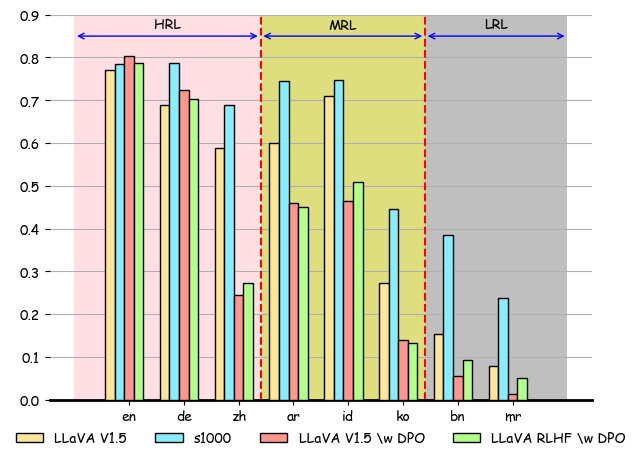

In [186]:
draw()

In [8]:
# uk vi th ta sw